# 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 데이터 수집

In [2]:
df_raw = pd.read_csv('C:/workspaces/project/kaggle/data/covid.csv',dtype={'id':str})

In [3]:
df_raw.head()

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,9999-99-99,97,2,27,97,...,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,9999-99-99,97,2,24,97,...,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,...,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,97,...,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,...,2,1,2,1,2,2,2,99,1,2


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566602 entries, 0 to 566601
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   566602 non-null  object
 1   sex                  566602 non-null  int64 
 2   patient_type         566602 non-null  int64 
 3   entry_date           566602 non-null  object
 4   date_symptoms        566602 non-null  object
 5   date_died            566602 non-null  object
 6   intubed              566602 non-null  int64 
 7   pneumonia            566602 non-null  int64 
 8   age                  566602 non-null  int64 
 9   pregnancy            566602 non-null  int64 
 10  diabetes             566602 non-null  int64 
 11  copd                 566602 non-null  int64 
 12  asthma               566602 non-null  int64 
 13  inmsupr              566602 non-null  int64 
 14  hypertension         566602 non-null  int64 
 15  other_disease        566602 non-nu

# Data Preprocessing

#### 1. patient_type=1인 사람 제거
- patient_type=1 이면 99% 생존  → 1인경우는 무조건 생존으로 나올 가능성이 높음. 모델링에 적절하지 않다.
- patient_type=2 이면 50% 생존

In [5]:
df1 = df_raw[df_raw.patient_type != 1] 
df1['patient_type'].head(20)

2     2
3     2
4     2
5     2
6     2
9     2
10    2
12    2
21    2
30    2
31    2
33    2
36    2
40    2
41    2
43    2
45    2
46    2
47    2
48    2
Name: patient_type, dtype: int64

#### 2. 두 번 이상 방문한 사람 특성 확인 후 삭제

In [6]:
# ID 별 방문횟수 CNT
df1['id'] = df1['id'].astype(str)
df1_sub = df1.copy()
df1_sub['visit'] = 1

C:\Users\u\.conda\envs\env_cpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
VISIT_CNT = df1_sub.pivot_table(index = ['id'], values = ['visit'], aggfunc=np.sum)

In [8]:
VISIT_CNT2 = VISIT_CNT[VISIT_CNT.visit != 1] ; VISIT_CNT2     # 두 번 이상 방문한사람

,visit
id,
0.00E+00,38
1.00E+47,2
1.00E+53,2
1.00E+84,2
1.00E+87,2
...,...
7.00E+01,2
7.00E+02,2
7.00E+58,2


In [9]:
PERSON_BY_VISIT = VISIT_CNT2.groupby(['visit']).size(); PERSON_BY_VISIT

visit
2     155
3      42
4       5
38      1
dtype: int64

- 두 번 이상 방문한 사람이 203명
- 근데 id = 0.00E+00 인 사람은 38번 카운팅되서 이 id인사람 삭제 id가 너무 작은 수여서 csv로 저장될때 그냥 0으로 저장됨
- 두번 이상 방문한 사람 모두 소수점 저장될 때 E 표기법으로 저장되어서 동일한 사람처럼 보이지만  
성별이 바뀌는 것으로 보아 동일한 사람이 아닌데 동일한 사람처럼 저장된 것임
- 그래서 2번 이상 방문한 것으로 counting 되는 사람의 row 모두 지워야 함

In [10]:
df2 = pd.merge(df1, VISIT_CNT, on = ['id'])

df2 = df2[df2.visit == 1]     # 두 번 이상 방문한 사람 삭제
df2[df2.visit != 1]           # 잘 삭제됬는지 확인 → OK! 

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,visit


 #### 3. 남성에서 임신 여부 변수 97 (해당없음) → 2 (아니오) 로 변경

In [11]:
df2['pregnancy'] = df2['pregnancy'].apply(lambda x : 2 if x == 97 else x)

In [12]:
df2[df2.sex == 2]     # 남성 → 임신변수 모두 2로 변경됨 확인

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,visit
1,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,2,...,2,2,2,2,2,2,99,1,2,1
3,1beec8,2,2,16-04-2020,16-04-2020,29-04-2020,2,1,47,2,...,2,2,2,2,2,2,99,1,1,1
4,1.75E+56,2,2,22-04-2020,13-04-2020,9999-99-99,2,2,63,2,...,1,2,2,2,2,2,99,1,2,1
7,126f5c,2,2,02-05-2020,02-05-2020,9999-99-99,2,2,28,2,...,2,2,2,2,2,2,99,1,2,1
11,0d968b,2,2,24-04-2020,21-04-2020,9999-99-99,2,2,56,2,...,2,2,2,2,2,2,99,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121905,1c5d42,2,2,13-06-2020,13-06-2020,9999-99-99,1,2,40,2,...,2,1,2,2,2,2,99,3,1,1
121907,0f6881,2,2,21-06-2020,17-06-2020,9999-99-99,2,2,76,2,...,1,2,2,2,2,2,99,3,2,1
121908,093a47,2,2,02-05-2020,02-05-2020,9999-99-99,2,1,45,2,...,2,2,2,2,2,2,99,3,2,1
121909,067bbd,2,2,07-06-2020,24-05-2020,9999-99-99,1,1,68,2,...,1,2,2,1,2,2,2,3,1,1


#### 4. 모든 변수 98, 99 → 3으로 변경

In [13]:
df3 = df2.copy()
for i in ['intubed', 'pregnancy','pneumonia', 'diabetes', 'copd', 'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
          'obesity', 'renal_chronic', 'tobacco', 'contact_other_covid', 'icu']:
    df3[i] = df3[i].apply(lambda x : 3 if x ==98 or x == 99 else x)   

In [14]:
check = []
for i in ['intubed', 'pregnancy', 'pneumonia', 'diabetes', 'copd', 'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular', 'obesity', 'renal_chronic', 'tobacco' , 'contact_other_covid', 'icu']:
    check.append(df3[df3[i]==98])
print(check)     # 제대로 변경됨 확인!

[Empty DataFrame
Columns: [id, sex, patient_type, entry_date, date_symptoms, date_died, intubed, pneumonia, age, pregnancy, diabetes, copd, asthma, inmsupr, hypertension, other_disease, cardiovascular, obesity, renal_chronic, tobacco, contact_other_covid, covid_res, icu, visit]
Index: []

[0 rows x 24 columns], Empty DataFrame
Columns: [id, sex, patient_type, entry_date, date_symptoms, date_died, intubed, pneumonia, age, pregnancy, diabetes, copd, asthma, inmsupr, hypertension, other_disease, cardiovascular, obesity, renal_chronic, tobacco, contact_other_covid, covid_res, icu, visit]
Index: []

[0 rows x 24 columns], Empty DataFrame
Columns: [id, sex, patient_type, entry_date, date_symptoms, date_died, intubed, pneumonia, age, pregnancy, diabetes, copd, asthma, inmsupr, hypertension, other_disease, cardiovascular, obesity, renal_chronic, tobacco, contact_other_covid, covid_res, icu, visit]
Index: []

[0 rows x 24 columns], Empty DataFrame
Columns: [id, sex, patient_type, entry_date, da

#### 5. 사망여부 변수 추가
- date_died = 99-99-9999인 사람은 DEATH=0 (생존)
- date_died 에 날짜가 입력되어 있는 사람은 DEATH=1 (사망)

In [15]:
df4 = df3.copy()
df4['DEATH'] = np.where(df4['date_died']=='9999-99-99', 0, 1)

In [16]:
df4[df4.date_died == '9999-99-99'].DEATH

0         0
1         0
4         0
5         0
6         0
         ..
121907    0
121908    0
121909    0
121911    0
121912    0
Name: DEATH, Length: 88993, dtype: int32

In [17]:
df4[df4.date_died != '9999-99-99'].DEATH

2         1
3         1
12        1
14        1
16        1
         ..
121899    1
121901    1
121902    1
121906    1
121910    1
Name: DEATH, Length: 32426, dtype: int32

In [18]:
df4

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,visit,DEATH
0,167386,1,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,...,2,2,1,2,2,3,1,2,1,0
1,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,2,...,2,2,2,2,2,3,1,2,1,0
2,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,...,2,1,2,2,2,3,1,2,1,1
3,1beec8,2,2,16-04-2020,16-04-2020,29-04-2020,2,1,47,2,...,2,2,2,2,2,3,1,1,1,1
4,1.75E+56,2,2,22-04-2020,13-04-2020,9999-99-99,2,2,63,2,...,2,2,2,2,2,3,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121908,093a47,2,2,02-05-2020,02-05-2020,9999-99-99,2,1,45,2,...,2,2,2,2,2,3,3,2,1,0
121909,067bbd,2,2,07-06-2020,24-05-2020,9999-99-99,1,1,68,2,...,2,2,1,2,2,2,3,1,1,0
121910,5.60E+40,2,2,08-05-2020,08-05-2020,13-05-2020,1,1,48,2,...,2,2,2,2,2,2,3,1,1,1
121911,150615,1,2,12-05-2020,09-05-2020,9999-99-99,2,1,31,3,...,2,2,2,2,2,3,3,2,1,0


#### 6. 생존자 사망일 Imputation 하기!
- Entry date, symptom date, death date 중 가장 마지막 날짜로 생존자 사망일 imputation
- 원래 date_died 변수는 손대지 않고 last_date로 새 변수 생성

In [19]:
entry = df4[df4.entry_date != '9999-99-99'].entry_date
sym = df4[df4.date_symptoms != '9999-99-99'].date_symptoms
dth = df4[df4.date_died != '9999-99-99'].date_died

In [20]:
tot_date = pd.concat([entry, sym, dth], ignore_index=True)
tot_date

0         06-04-2020
1         17-04-2020
2         13-04-2020
3         16-04-2020
4         22-04-2020
             ...    
275259    13-05-2020
275260    19-06-2020
275261    05-06-2020
275262    14-06-2020
275263    13-05-2020
Length: 275264, dtype: object

In [21]:
tot_date = pd.to_datetime(tot_date, format = '%d-%m-%Y')
tot_date

0        2020-04-06
1        2020-04-17
2        2020-04-13
3        2020-04-16
4        2020-04-22
            ...    
275259   2020-05-13
275260   2020-06-19
275261   2020-06-05
275262   2020-06-14
275263   2020-05-13
Length: 275264, dtype: datetime64[ns]

In [22]:
tot_date.max()     # 가장 최근날짜 2020-06-29

Timestamp('2020-06-29 00:00:00')

In [23]:
df5 = df4.copy()
df5['last_date'] = df4['date_died'].apply(lambda x : '29-06-2020' if x == '9999-99-99' else x)

In [24]:
df5[df5.DEATH == 0].last_date

0         29-06-2020
1         29-06-2020
4         29-06-2020
5         29-06-2020
6         29-06-2020
             ...    
121907    29-06-2020
121908    29-06-2020
121909    29-06-2020
121911    29-06-2020
121912    29-06-2020
Name: last_date, Length: 88993, dtype: object

#### 7. 날짜 이상인 사람 삭제하기

#### 1) symptom date가 entry date보다 늦은 사람 제거
- entry_date - date_symptoms < 0

In [25]:
df6_sub1 = df5.copy()
df6_sub1['d_ent'] = pd.to_datetime(df6_sub1['entry_date'], format = "%d-%m-%Y") 
df6_sub1['d_sym'] = pd.to_datetime(df6_sub1['date_symptoms'], format = "%d-%m-%Y")
df6_sub1['d_last'] = pd.to_datetime(df6_sub1['last_date'], format = "%d-%m-%Y")
df6_sub1.head()

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,tobacco,contact_other_covid,covid_res,icu,visit,DEATH,last_date,d_ent,d_sym,d_last
0,167386,1,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,...,2,3,1,2,1,0,29-06-2020,2020-04-06,2020-04-01,2020-06-29
1,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,2,...,2,3,1,2,1,0,29-06-2020,2020-04-17,2020-04-10,2020-06-29
2,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,...,2,3,1,2,1,1,22-04-2020,2020-04-13,2020-04-13,2020-04-22
3,1beec8,2,2,16-04-2020,16-04-2020,29-04-2020,2,1,47,2,...,2,3,1,1,1,1,29-04-2020,2020-04-16,2020-04-16,2020-04-29
4,1.75E+56,2,2,22-04-2020,13-04-2020,9999-99-99,2,2,63,2,...,2,3,1,2,1,0,29-06-2020,2020-04-22,2020-04-13,2020-06-29


In [26]:
df6_sub1['diff1'] = (df6_sub1['d_ent'] - df6_sub1['d_sym']).dt.days.astype(int)
df6_sub1 = df6_sub1[df6_sub1.diff1 >= 0]     # 제외 대상자 삭제 
df6_sub1[df6_sub1.diff1 < 0]                 # 잘 제거되었는지 확인

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,contact_other_covid,covid_res,icu,visit,DEATH,last_date,d_ent,d_sym,d_last,diff1


#### 2) entry date, symptom date이 last date 보다 늦은 사람 제거
- last_date - date_symptoms < 0  또는 last_date - entry_date < 0

In [27]:
df6_sub2 = df6_sub1.copy()
df6_sub2['diff2'] = (df6_sub2['d_last'] - df6_sub2['d_sym']).dt.days.astype(int)
df6_sub2['diff3'] = (df6_sub2['d_last'] - df6_sub2['d_ent']).dt.days.astype(int)

##### 제외 대상자삭제

In [29]:
df6_sub2 = df6_sub2[df6_sub2.diff2 >= 0]
df6_sub2 = df6_sub2[df6_sub2.diff3 >= 0]

##### 잘 제거되었는지 확인

In [30]:
df6_sub2[df6_sub2.diff2 < 0]
df6_sub2[df6_sub2.diff3 < 0]

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,icu,visit,DEATH,last_date,d_ent,d_sym,d_last,diff1,diff2,diff3


In [31]:
df6 = df6_sub2.copy()
df6.head()

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,icu,visit,DEATH,last_date,d_ent,d_sym,d_last,diff1,diff2,diff3
0,167386,1,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,...,2,1,0,29-06-2020,2020-04-06,2020-04-01,2020-06-29,5,89,84
1,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,2,...,2,1,0,29-06-2020,2020-04-17,2020-04-10,2020-06-29,7,80,73
2,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,...,2,1,1,22-04-2020,2020-04-13,2020-04-13,2020-04-22,0,9,9
3,1beec8,2,2,16-04-2020,16-04-2020,29-04-2020,2,1,47,2,...,1,1,1,29-04-2020,2020-04-16,2020-04-16,2020-04-29,0,13,13
4,1.75E+56,2,2,22-04-2020,13-04-2020,9999-99-99,2,2,63,2,...,2,1,0,29-06-2020,2020-04-22,2020-04-13,2020-06-29,9,77,68


In [32]:
len(df6)

121395

#### 8. 사망 또는 관찰기간 변수 생성
- 사망한 사람은 증상발현~사망까지 기간
- 생존한 사람은 증상발현~마지막관찰일(2020-06-29)까지 기간
- d_last - d_sym

In [33]:
df6['diff_days'] = (df6.d_last - df6.d_sym).dt.days.astype(int)

In [34]:
df6.head()

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,visit,DEATH,last_date,d_ent,d_sym,d_last,diff1,diff2,diff3,diff_days
0,167386,1,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,...,1,0,29-06-2020,2020-04-06,2020-04-01,2020-06-29,5,89,84,89
1,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,2,...,1,0,29-06-2020,2020-04-17,2020-04-10,2020-06-29,7,80,73,80
2,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,...,1,1,22-04-2020,2020-04-13,2020-04-13,2020-04-22,0,9,9,9
3,1beec8,2,2,16-04-2020,16-04-2020,29-04-2020,2,1,47,2,...,1,1,29-04-2020,2020-04-16,2020-04-16,2020-04-29,0,13,13,13
4,1.75E+56,2,2,22-04-2020,13-04-2020,9999-99-99,2,2,63,2,...,1,0,29-06-2020,2020-04-22,2020-04-13,2020-06-29,9,77,68,77


In [35]:
df6['diff_days'].describe() 

count    121395.000000
mean         32.845092
std          27.360004
min           0.000000
25%          11.000000
50%          24.000000
75%          49.000000
max         180.000000
Name: diff_days, dtype: float64

In [37]:
df6[df6['diff_days'] < 0]

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,visit,DEATH,last_date,d_ent,d_sym,d_last,diff1,diff2,diff3,diff_days


# 시각화

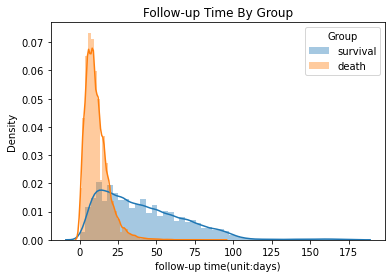

In [40]:
sns.distplot(df6[df6.DEATH==0]["diff_days"], label="survival")
sns.distplot(df6[df6.DEATH==1]["diff_days"], label="death")

plt.title("Follow-up Time By Group")
plt.legend(title="Group")
plt.xlabel("follow-up time(unit:days)")
plt.ylabel("Density")
plt.show()

##### 연령군 나누기 ()

In [41]:
df7 = df6.copy()

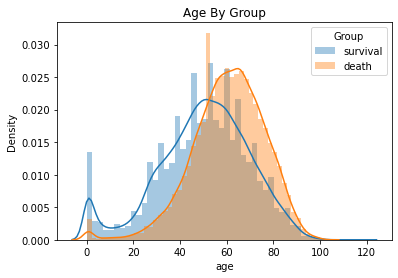

In [42]:
sns.distplot(df7[df7.DEATH==0]["age"], label="survival")
sns.distplot(df7[df7.DEATH==1]["age"], label="death")

plt.title("Age By Group")
plt.legend(title="Group")
plt.xlabel("age")
plt.ylabel("Density")
plt.show()

In [43]:
df7['age'].describe() 

count    121395.000000
mean         52.957577
std          19.237785
min           0.000000
25%          42.000000
50%          55.000000
75%          66.000000
max         118.000000
Name: age, dtype: float64

In [44]:
df7['age_grp'] = np.where(df7['age']<20, 1,
                          np.where(df7['age']<40, 2,
                                   np.where(df7['age']<60, 3,
                                            np.where(df7['age']<80, 4, 
                                                     np.where(df7['age']>=80, 5, np.nan)))))
df7[df7['age_grp'].isnull()==True]

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,DEATH,last_date,d_ent,d_sym,d_last,diff1,diff2,diff3,diff_days,age_grp


##### 연령 그룹 별 사람 수 확인

In [45]:
PERSON_BY_AGE = df7.groupby(['age_grp']).size(); PERSON_BY_AGE

age_grp
1.0     6632
2.0    19800
3.0    47384
4.0    39347
5.0     8232
dtype: int64

##### 분석에 필요없는 변수 삭제 후 Export

In [46]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121395 entries, 0 to 121912
Data columns (total 34 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   id                   121395 non-null  object        
 1   sex                  121395 non-null  int64         
 2   patient_type         121395 non-null  int64         
 3   entry_date           121395 non-null  object        
 4   date_symptoms        121395 non-null  object        
 5   date_died            121395 non-null  object        
 6   intubed              121395 non-null  int64         
 7   pneumonia            121395 non-null  int64         
 8   age                  121395 non-null  int64         
 9   pregnancy            121395 non-null  int64         
 10  diabetes             121395 non-null  int64         
 11  copd                 121395 non-null  int64         
 12  asthma               121395 non-null  int64         
 13  inmsupr       

In [47]:
df8 = df7.loc[:, ['id', 'sex',  'intubed', 'pneumonia', 'age', 'pregnancy', 
                  'diabetes', 'copd', 'asthma', 'inmsupr', 'hypertension', 
                  'other_disease', 'obesity', 'cardiovascular', 'renal_chronic', 
                  'tobacco', 'contact_other_covid', 'covid_res','icu', 'DEATH',
                  'd_ent', 'd_sym', 'd_last', 'diff_days', 'age_grp']]
df8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121395 entries, 0 to 121912
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   id                   121395 non-null  object        
 1   sex                  121395 non-null  int64         
 2   intubed              121395 non-null  int64         
 3   pneumonia            121395 non-null  int64         
 4   age                  121395 non-null  int64         
 5   pregnancy            121395 non-null  int64         
 6   diabetes             121395 non-null  int64         
 7   copd                 121395 non-null  int64         
 8   asthma               121395 non-null  int64         
 9   inmsupr              121395 non-null  int64         
 10  hypertension         121395 non-null  int64         
 11  other_disease        121395 non-null  int64         
 12  obesity              121395 non-null  int64         
 13  cardiovascular

In [48]:
df8.to_csv('C:/workspaces/project/kaggle/data/d_final.csv', encoding='utf-8', index=False, line_terminator='\n')